# ReDU Study

In [1]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy.stats as stats
import torch
import umap
from metvae.model import MetVAE

import matplotlib.pyplot as plt
%matplotlib inline

/Users/hlin1239/anaconda3/envs/metvae-pypi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Import

In [2]:
abundance_redu = pd.read_csv('../data/redu/redu_abundance.csv', index_col=0)

# The sample meta data
smd_redu = pd.read_csv('../data/redu/redu_smd.csv', index_col=0)

### Confounders

In [3]:
smd_redu['HealthStatus'].value_counts()

HealthStatus
unknown      11131
healthy       5455
unhealthy     3744
Name: count, dtype: int64

In [4]:
smd_redu['MassSpectrometer'].value_counts()

MassSpectrometer
impact Series        10768
Q Exactive Series     7359
Other Instruments     2203
Name: count, dtype: int64

## Run the MetVAE model

In [5]:
torch.manual_seed(123)
np.random.seed(123)

max_epochs=1000
learning_rate=1e-2

model = MetVAE(data=abundance_redu,
               features_as_rows=True,
               meta=smd_redu,
               categorical_covariate_keys=['ChromatographyAndPhase', 'MassSpectrometer'],
               latent_dim=1000,
               use_gpu=False,
               logging=False)

model.model.load_state_dict(torch.load('../results/outputs/redu/model_state.pth', map_location=torch.device('cpu')))
model.model.eval() 

/var/folders/rn/10vtwtd944j73gfdxc_pbl680000gr/T/ipykernel_23055/2688877205.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.model.load_state_dict(torch.load('../r

VAE(
  (encnorm): BatchNorm1d(3929, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (encode_mu): Linear(in_features=3929, out_features=1000, bias=True)
  (encode_logvar): Linear(in_features=3929, out_features=1000, bias=True)
  (decode_mu): Linear(in_features=1000, out_features=3929, bias=True)
)

In [6]:
impute_clr_data = model.impute_zeros()
shift = model.shift
impute_log_data = impute_clr_data + shift
impute_data = np.exp(impute_log_data)

## UMAP

In [7]:
reducer = umap.UMAP(n_components=2, random_state=1234)

# Perform UMAP on the raw data
umap_result1 = reducer.fit_transform(abundance_redu.T)
# Perform UMAP on the imputed data
umap_result2 = reducer.fit_transform(impute_data)

# Create a DataFrame with UMAP results
umap_df = pd.DataFrame(np.hstack([umap_result1, umap_result2]),
                       columns=['UMAP1_Raw', 'UMAP2_Raw', 'UMAP1_Imputed', 'UMAP2_Imputed'],
                       index = smd_redu.index)
umap_df = pd.concat([umap_df, smd_redu], axis=1)

/Users/hlin1239/anaconda3/envs/metvae-pypi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/hlin1239/anaconda3/envs/metvae-pypi/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/hlin1239/anaconda3/envs/metvae-pypi/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Sum of Squares

In [8]:
def compute_sst(data):
    overall_mean = np.mean(data, axis=0)
    sst = np.sum((data - overall_mean) ** 2)

    return sst

def compute_ssb(data, labels):
    overall_mean = np.mean(data, axis=0)
    ssb = 0
    unique_labels = np.unique(labels)

    for label in unique_labels:
        group_data = data[labels == label, :]
        group_mean = np.mean(group_data, axis=0)
        n_group = group_data.shape[0]
        ssb += n_group * np.sum((group_mean - overall_mean) ** 2)

    return ssb

In [9]:
sst = compute_sst(umap_df[['UMAP1_Raw', 'UMAP2_Raw']].values)
ssb = compute_ssb(umap_df[['UMAP1_Raw', 'UMAP2_Raw']].values, umap_df['MassSpectrometer'].values)
ssb_norm_raw1 = ssb/sst

sst = compute_sst(umap_df[['UMAP1_Raw', 'UMAP2_Raw']].values)
ssb = compute_ssb(umap_df[['UMAP1_Raw', 'UMAP2_Raw']].values, umap_df['HealthStatus'].values)
ssb_norm_raw2 = ssb/sst

sst = compute_sst(umap_df[['UMAP1_Imputed', 'UMAP2_Imputed']].values)
ssb = compute_ssb(umap_df[['UMAP1_Imputed', 'UMAP2_Imputed']].values, umap_df['MassSpectrometer'].values)
ssb_norm_impute1 = ssb/sst

sst = compute_sst(umap_df[['UMAP1_Imputed', 'UMAP2_Imputed']].values)
ssb = compute_ssb(umap_df[['UMAP1_Imputed', 'UMAP2_Imputed']].values, umap_df['HealthStatus'].values)
ssb_norm_impute2 = ssb/sst

### Visualization

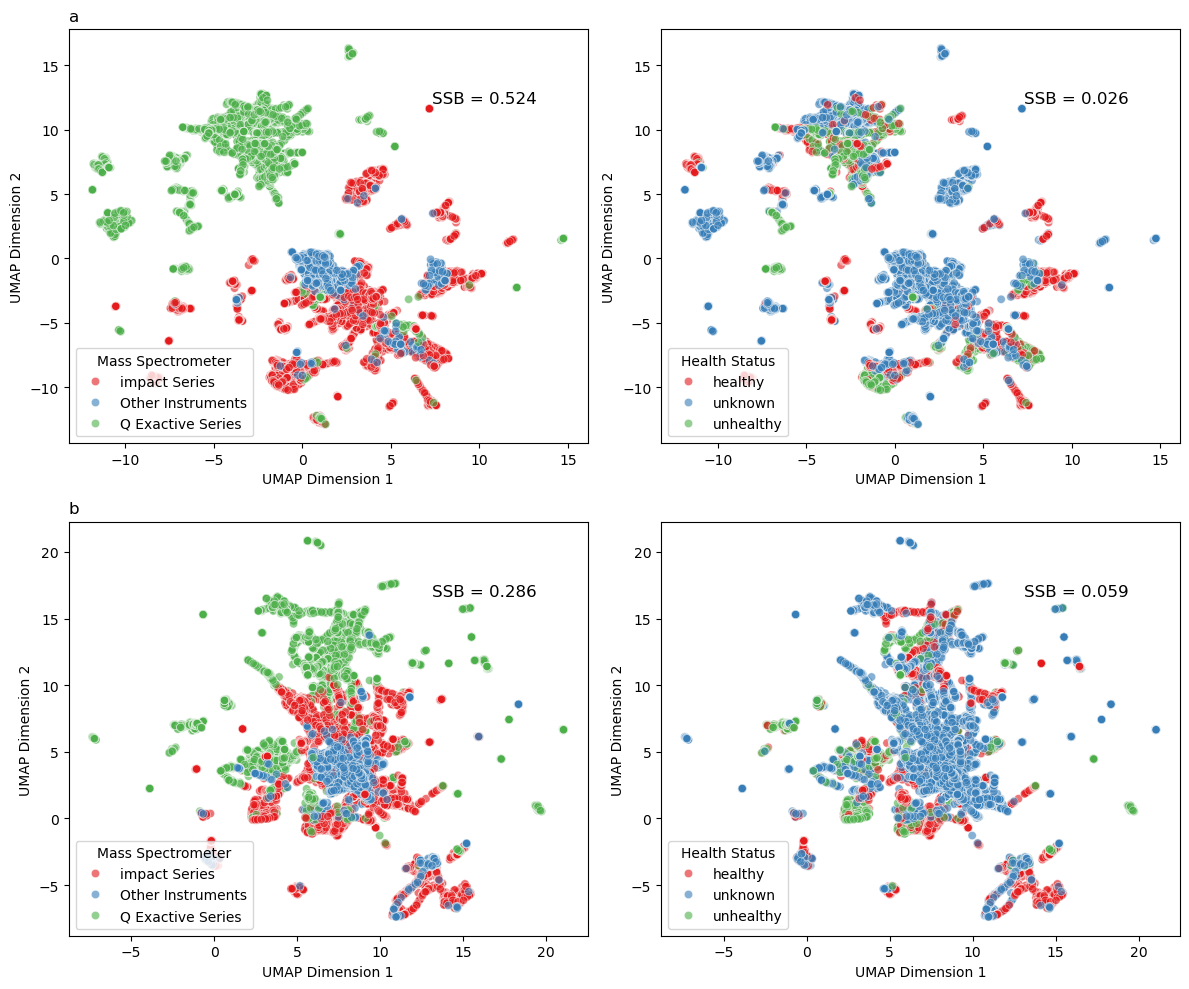

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.scatterplot(x='UMAP1_Raw', y='UMAP2_Raw', hue='MassSpectrometer', 
                data=umap_df, palette='Set1', alpha=0.6, ax=axes[0, 0])
axes[0, 0].set_xlabel('UMAP Dimension 1')
axes[0, 0].set_ylabel('UMAP Dimension 2')
axes[0, 0].legend(title='Mass Spectrometer', loc='lower left')
axes[0, 0].set_title('a', loc='left')
axes[0, 0].text(0.70, 0.85, f'SSB = {ssb_norm_raw1:.3f}', 
                transform=axes[0, 0].transAxes, fontsize=12, 
                verticalalignment='top')

sns.scatterplot(x='UMAP1_Raw', y='UMAP2_Raw', hue='HealthStatus', 
                data=umap_df, palette='Set1', alpha=0.6, ax=axes[0, 1])
axes[0, 1].set_xlabel('UMAP Dimension 1')
axes[0, 1].set_ylabel('UMAP Dimension 2')
axes[0, 1].legend(title='Health Status', loc='lower left')
axes[0, 1].text(0.70, 0.85, f'SSB = {ssb_norm_raw2:.3f}', 
                transform=axes[0, 1].transAxes, fontsize=12, 
                verticalalignment='top')

sns.scatterplot(x='UMAP1_Imputed', y='UMAP2_Imputed', hue='MassSpectrometer', 
                data=umap_df, palette='Set1', alpha=0.6, ax=axes[1, 0])
axes[1, 0].set_xlabel('UMAP Dimension 1')
axes[1, 0].set_ylabel('UMAP Dimension 2')
axes[1, 0].legend(title='Mass Spectrometer', loc='lower left')
axes[1, 0].set_title('b', loc='left')
axes[1, 0].text(0.70, 0.85, f'SSB = {ssb_norm_impute1:.3f}', 
                transform=axes[1, 0].transAxes, fontsize=12, 
                verticalalignment='top')

sns.scatterplot(x='UMAP1_Imputed', y='UMAP2_Imputed', hue='HealthStatus', 
                data=umap_df, palette='Set1', alpha=0.6, ax=axes[1, 1])
axes[1, 1].set_xlabel('UMAP Dimension 1')
axes[1, 1].set_ylabel('UMAP Dimension 2')
axes[1, 1].legend(title='Health Status', loc='lower left')
axes[1, 1].text(0.70, 0.85, f'SSB = {ssb_norm_impute2:.3f}', 
                transform=axes[1, 1].transAxes, fontsize=12, 
                verticalalignment='top')

plt.tight_layout()
plt.savefig('../results/figures/main_redu.pdf', bbox_inches='tight')
plt.show()